In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Model Object 

We built a model that can perform the forward pass, backward pass, and ancillary tasks like measuring accuracy. We have built all this by writing a fair bit of code and making modifications in some decently-sized blocks of code. It’s beginning to make more sense to make our model an object itself, especially since we will want to do things like save and load this object to use for future prediction tasks. We will also use this object to cut down on some of the more common lines of code, making it easier to work with our current code base and build new models. To do this model object conversion, we’ll use the last model we were working on, the regression model with sine data:

Once we have the data, our first step for the model class is to add in the various layers we want. Thus, we can begin our model class by doing:

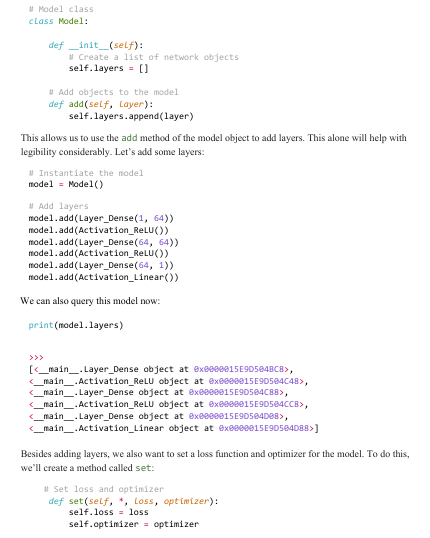

The use of the asterisk in the parameter definitions notes that the subsequent parameters (​loss and ​optimizer​ in this case) are keyword arguments. Since they have no default value assigned, they are required keyword arguments, which means that they have to be passed by names and values, making code more legible.

Now we can add a call to this method into our newly-created model object, and pass the loss and optimizer objects:

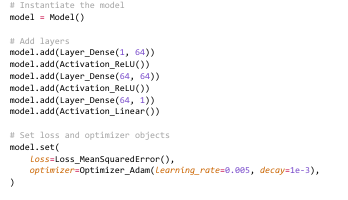

After we’ve set our model’s layers, loss function, and optimizer, the next step is to train, so we’ll add a train method. For now, we’ll make it a placeholder and fill it in soon:
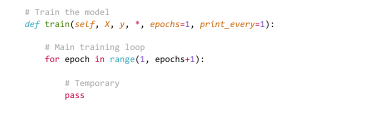
The ​forward​ method sets training samples as ​self.output​. This property is common with other layers. There’s no need for a backward method here since we’ll never use it. It might seem silly right now to even have this class, but it should hopefully become clear how we’re going to use this shortly. The next thing we’re going to do is set the previous and next layer properties for each of the model’s layers. We’ll create a method called ​finalize​ in the ​Model​ ​class:
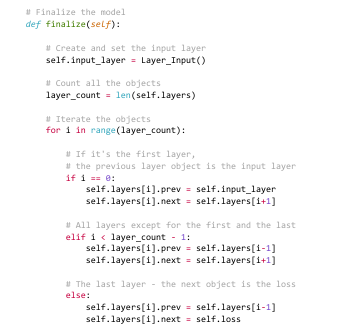
This code creates an input layer and sets ​next​ and ​prev​ references for each layer contained within the ​self.layers​ list of a model object. We wanted to create the ​Layer_Input​ class to set the ​prev​ property of the first hidden layer in a loop since we are going to call all of the layers in a uniform way. The ​next​ layer for the final layer will be the loss, which we already have created. Now that we have the necessary layer information for our model object to perform a forward pass, let’s add a forward method. We will use this forward method both for when we train and later when we just want to predict, which is also called ​model​ ​inference​. Continuing the code within the ​Model​ class:


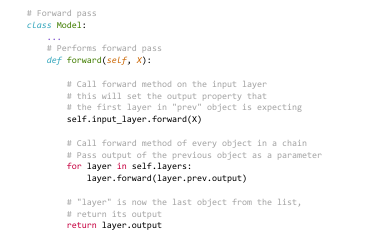



In this case, we take in ​X​ (input data), then simply pass this data through the ​input_layer​ in the Model​ object, which creates an ​output​ attribute in this object. From here, we begin iterating over the ​self.layers​, the layers starting with the first hidden layer. We perform a forward pass on the ​layer.prev.output​, the output data of the previous layer, for each layer. For the first hidden layer, the ​layer.prev​ is ​self.input_layer​. The ​output​ attribute is created for each layer when we call the ​forward​ method, which is then used as input to a ​forward​ method call on the next layer. Once we’ve iterated over all of the layers, we return the final layer’s output. That’s a forward pass, and now let’s go ahead and add this forward pass method call to the ​train method in the ​Model​ class:

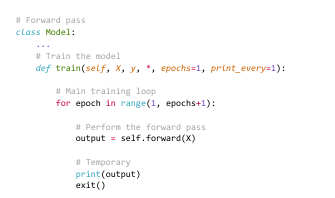

Full ​Model​ class up to this point:

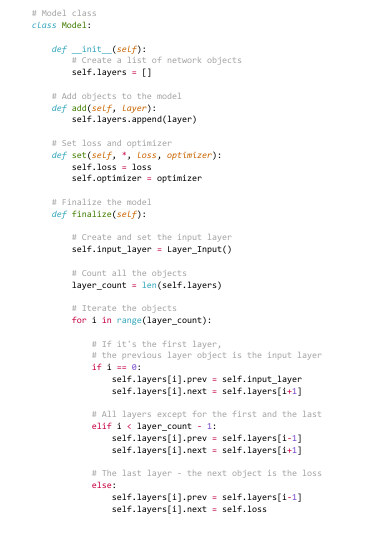

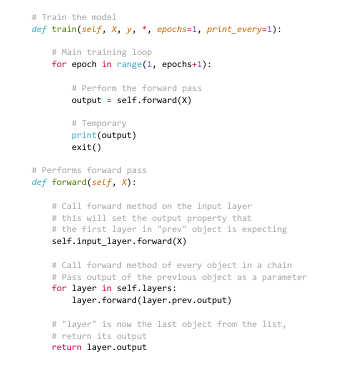
Finally, we can add in the ​finalize​ method call to the main code (recall this method makes, among other things, the model’s layers aware of their previous and next layers).


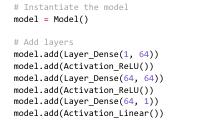

Where ​i​ is the index for the layer in the list of layers. We’ll put this code into the ​finalize method. The full code for that method so far:

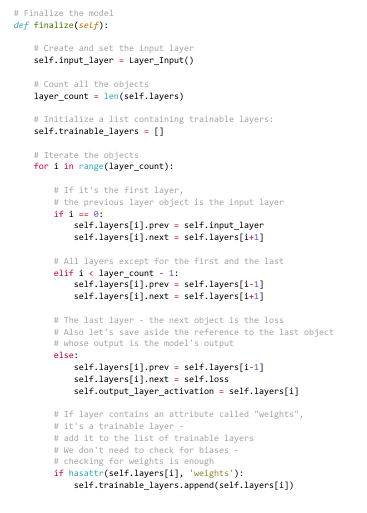

Next, we’ll modify the common ​Loss​ class to contain the following:
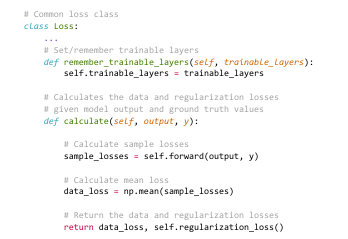

The ​remember_trainable_layers​ method in the common ​Loss​ class “tells” the loss object which layers in the ​Model​ object are trainable. The ​calculate​ method was modified to also return the ​self.regularization_loss()​ during a single call. The ​regularization_loss method currently requires a layer object, but with the ​self.trainable_layers​ property set in remember_trainable_layers​, method we can now iterate over the trainable layers to compute regularization loss for the entire model, rather than one layer at a time:

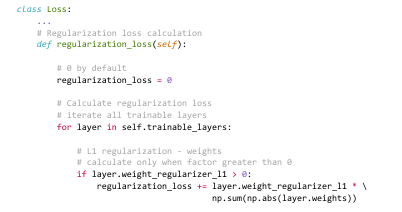

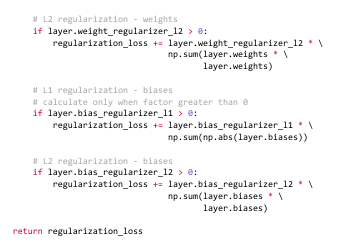

For calculating accuracy, we need predictions. So far, predicting has required different code depending on the type of model. For a softmax classifier, we do a ​np.argmax()​, but for regression, the prediction is the direct output because of the linear activation function being used in an output layer. Ideally, we’d have a prediction method that would choose the appropriate method for our model. To do this, we’ll add a ​predictions​ method to each activation function class:

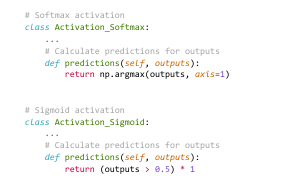

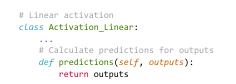

All the computations made inside the ​predictions​ functions are the same as those performed with appropriate models in previous chapters. While we have no plans for using the ReLU activation function for an output layer’s activation function, we’ll include it here for completeness:
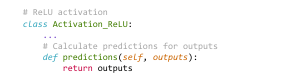

We still need to set a reference to the activation function for the final layer in the ​Model​ object. We can later call the ​predictions​ method, which will return predictions calculated from the outputs. We’ll set this in the ​Model​ class’ ​finalize​ method:

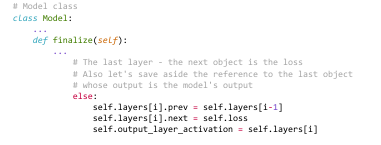

Just like the different prediction methods, we also calculate accuracy in different ways. We’re going to implement this in a way similar to the specific loss class’ objects implementation — we’ll create specific accuracy classes and their objects, which we’ll associate with models. First, we’ll write a common ​Accuracy​ class containing (for now) just a single method, calculate​, returning an accuracy calculated from comparison results. We’ve already added a call to the ​self.compare​ method that does not exist yet, but we’ll create it soon in other classes that will inherit from this ​Accuracy​ class. For now, it’s enough to know that it will return a list of ​True​ and ​False​ values, indicating if a prediction matches the ground-truth value. Next, we calculate the mean value (which treats ​True​ as ​1​ and ​False​ as ​0​) and return it as an accuracy. The


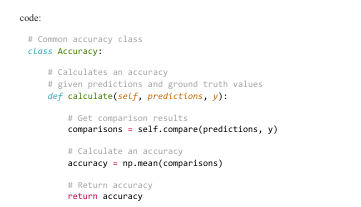

Next, we can work with this common ​Accuracy​ class, inheriting from it, then building further for specific types of models. In general, each of these classes will contain two methods: ​init​ (not to be confused with a Python class’ ​__init__​ m ​ ethod) for initialization from inside the model object and ​compare​ for performing comparison calculations. For regression, the ​init​ method will calculate an accuracy precision, the same as we have written previously for the regression model, and have been running before the training loop. The ​compare​ method will contain the actual comparison code we have implemented in the training loop itself, which uses self.precision​. Note that initialization won’t recalculate precision unless forced to do so by setting the ​reinit​ parameter to ​True​. This allows for multiple use-cases, including setting self.precision​ independently, calling ​init​ whenever needed (e.g., from outside of the model during its creation), and even calling it multiple times (which will become handy soon):

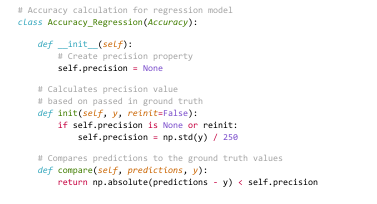

Finally, we’ll add a call to the previously created method ​remember_trainable_layers​ with the ​Loss​ class’ object, which we’ll do in the ​finalize​ method (​self.loss.remember_trainable_layers(self.trainable_layers)​). The full model class code so far:

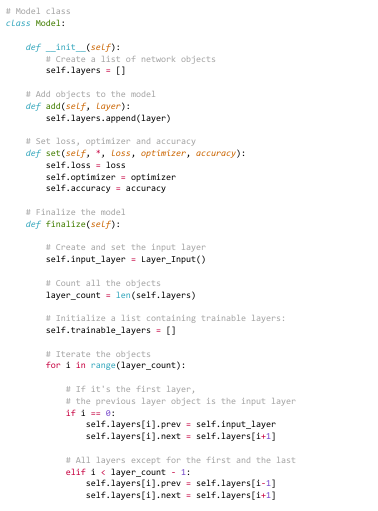

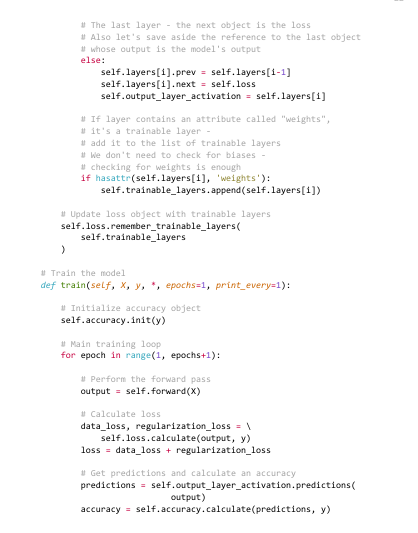
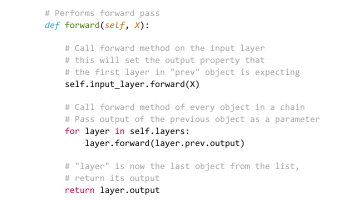

Full code for the ​Loss​ class:

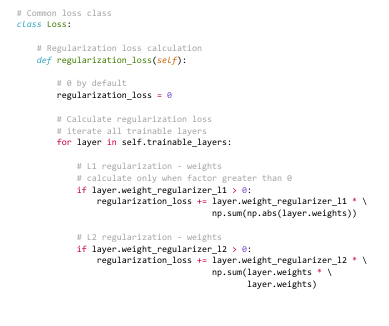

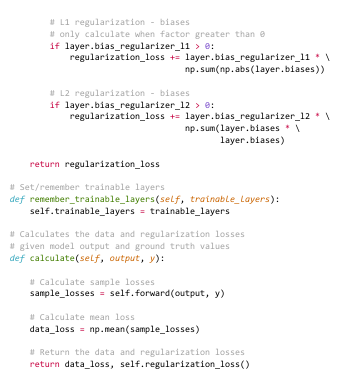

Now that we’ve done a full forward pass and have calculated loss and accuracy, we can begin the backward pass. The ​backward​ method in the ​Model​ class is structurally similar to the ​forward method, just in reverse and using different parameters. Following the backward pass in our previous training approach, we need to call the ​backward​ method of a loss object to create the dinputs​ property. Next, we’ll loop through all the layers in reverse order, calling their backward​ methods with the ​dinputs​ property of the next layer (in normal order) as a parameter, effectively backpropagating the gradient returned by that next layer. Remember that we have set the loss object as a ​next​ layer in the last, output layer.

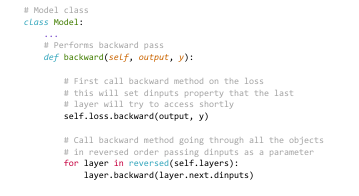

Next, we’ll add a call of this ​backward​ method to the end of the ​train​ method:
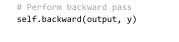

After this backward pass, the last action to perform is to optimize. We have previously been calling the optimizer object’s ​update_params​ method as many times as we had trainable layers. We have to make this code universal as well by looping through the list of trainable layers and calling ​update_params()​ in this loop:

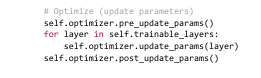



Then we can output useful information — here’s where this last parameter to the ​train​ method becomes handy:

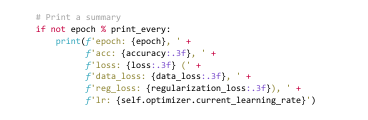

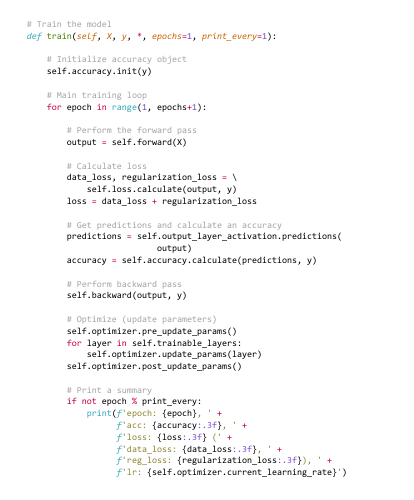

We can now pass the accuracy class’ object into the model and test our model’s performance:

X,y = data()

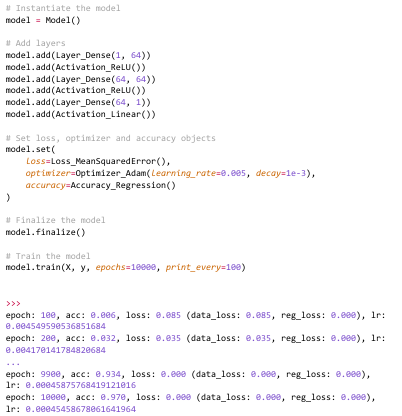

Our new model is behaving well, and now we’re able to make new models more easily with our ​Model​ class. We have to continue to modify these classes to handle for entirely new models. For example, we haven’t yet handled for binary logistic regression. For this, we need to add two things. First, we need to calculate the categorical accuracy:

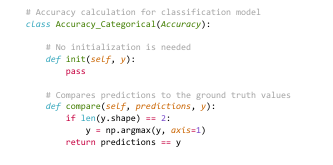


This is the same as the accuracy calculation for classification, just wrapped into a class and with an additional switch parameter. This switch disables one-hot to sparse label conversion while this class is used with the binary cross-entropy model, since this model always require the groundtrue values to be a 2D array and they're not one-hot encoded. Note that we do not perform any initialization here, but the method needs to exist since it’s going to be called from the ​train method of the ​Model​ class. The next thing that we need to add is the ability to validate the model using validation data. Validation requires only a forward pass and calculation of loss (just data loss). We’ll modify the ​calculate​ method of the ​Loss​ class to let it calculate the validation loss as well:

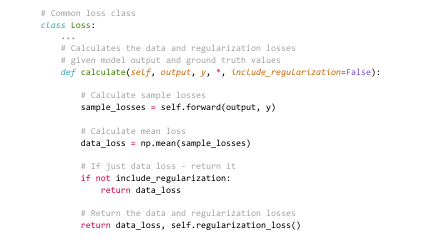

We’ve added a new parameter and condition to return just the data loss, as regularization loss is not being used in this case. To run it, we’ll pass predictions and targets the same way as with the training data. We will not return regularization loss by default, which means we need to update the call to this method in the ​train​ method to include regularization loss during training:

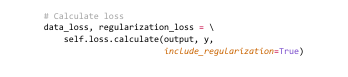

Then we can add the validation code to the ​train​ method in the ​Model​ class. We added the validation_data​ parameter to the function, which takes a tuple of validation data (samples and targets), the ​if​ statement to check if the validation data is present, and if it is — the code to perform a forward pass over these data, calculate loss and accuracy in the same way as during training and print the results:

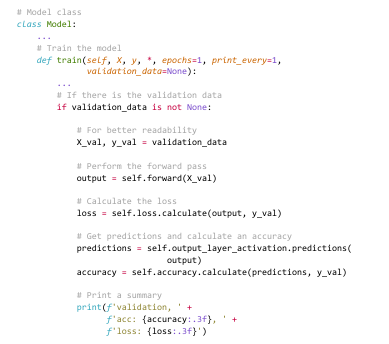



The full ​train​ method for the ​Model​ class:

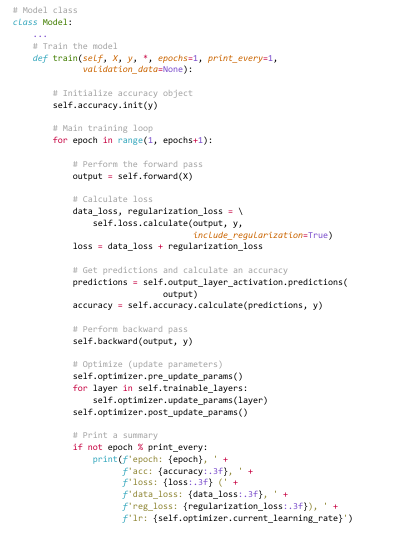

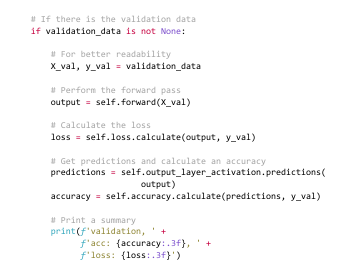

Now we can create the test data and test the binary logistic regression model with the following code:

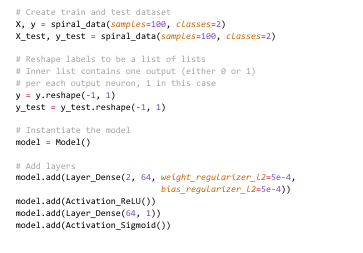

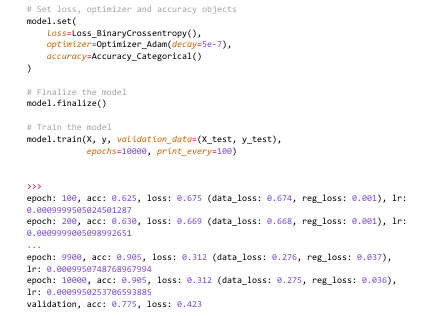

Now that we’re streamlining the forward and backward pass code, including validation, this is a good time to reintroduce dropout. Recall that dropout is a method to disable, or filter out, certain neurons in an attempt to regularize and improve our model’s ability to generalize. If dropout is employed in our model, we want to make sure to leave it out when performing validation and inference (predictions); in our previous code, we left it out by not calling its ​forward​ method during the forward pass during validation. Here we have a common method for performing a forward pass for both training and validation, so we need a different approach for turning off dropout — to inform the layers if we are during the training and let them “decide” on calculation to include. The first thing we’ll do is include a ​training​ boolean argument for the ​forward method in all the layer and activation classes, since we are calling them in a unified form:
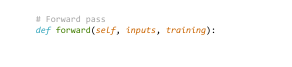

When we’re not training, we can set the output to the input directly in the ​Layer_Dropout​ class and return from the method without changing outputs:

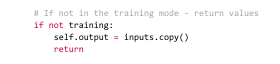

Next, we modify the ​forward​ method of our ​Model​ class to add the ​training​ parameter and a call to the ​forward​ methods of the layers to take this parameter’s value:

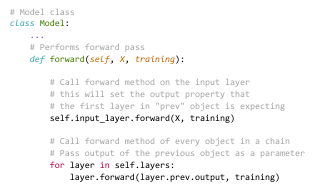
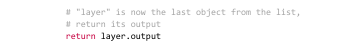
We also need to update the ​train​ method in the ​Model​ class since the ​training​ parameter in the forward method call will need to be set to ​True​:
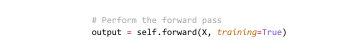

Then set to ​False​ during validation:
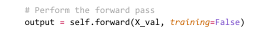

Making the full ​train​ method in the ​Model​ class:


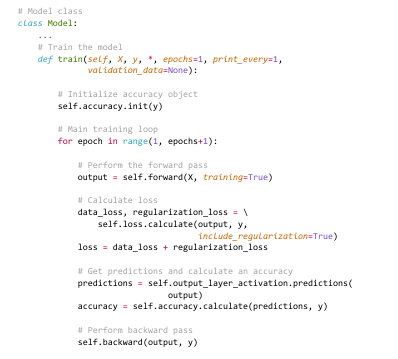

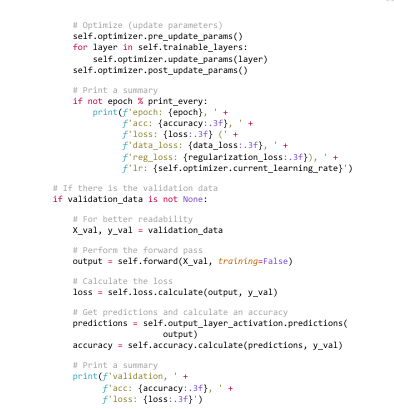

The last thing that we have to take care of, with the ​Model​ class, is the combined Softmax activation and CrossEntropy loss class that we created for faster gradient calculation. The challenge here is that previously we have been defining forward and backward passes by hand for every model separately. Now, however, we have loops over layers in both directions of calculations, a unified way of calculating outputs and gradients, and other improvements. We cannot just simply remove the Softmax activation and CrossEntropy loss and replace them with an object combining both. It won’t work with the code that we have so far, since we are handling the output activation function and loss in a specific way. Since the combined object contains just a backward pass optimization, let’s leave the forward pass as is, using separate Softmax activation and Categorical Cross-Entropy loss objects, and handle just for the backward pass. To start, we want to automatically decide if the current model is a classifier and if it uses the

Softmax activation and Categorical Cross-Entropy loss. This can be achieved by checking the class name of the last layer’s object, which is an activation function’s object, and by checking the class name of the loss function’s object. We’ll add this check to the end of the ​finalize method:

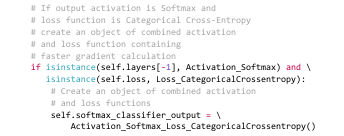


To make this check, we are using Python’s ​isinstance​ function, which returns ​True​ if a given object is an instance of a given class. If both of the tests return ​True​, we are setting a new property containing an object of the Activation_Softmax_Loss_CategoricalCrossentropy​ class. We also want to initialize this property with a value of ​None​ in the ​Model​ class’ constructor:


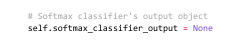

The last step is, during the backward pass, to check if this object is set and, if it is, to use it. To do so, we need to handle this case separately with a slightly modified version of the current code of the backward pass. First, we call the ​backward​ method of the combined object, then, since we won’t call the ​backward​ method of the activation function (the last object on a list of layers), set the ​dinputs​ of the object of this function with the gradient calculated within the activation/loss object. At the end, we can iterate all of the layers except for the last one and perform the backward pass on them:

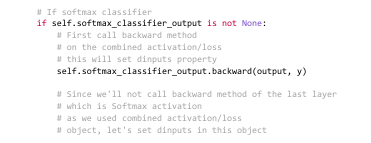

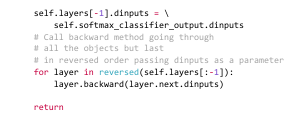



In [ ]:
import numpy as np


# Function to create spiral data (similar to nnfs)
def spiral_data(samples, classes):
    X = np.zeros((samples * classes, 2))  # Input features
    y = np.zeros(samples * classes, dtype='uint8')  # Class labels
    for class_number in range(classes):
        ix = range(samples * class_number, samples * (class_number + 1))
        r = np.linspace(0.0, 1, samples)  # Radius
        t = np.linspace(class_number * 4, (class_number + 1) * 4, samples) + np.random.randn(samples) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_number
    return X, y
# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask


    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# Input "layer"
class Layer_Input:

    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs, training):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return (outputs > 0.5) * 1


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs, training):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights *
                                              layer.weights)

            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases *
                                              layer.biases)

        return regularization_loss

    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers


    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Return accuracy
        return accuracy


# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250


    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision


# Model class
class Model:

    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)

    # Set loss, optimizer and accuracy
    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    # Finalize the model
    def finalize(self):

        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        self.loss.remember_trainable_layers(
            self.trainable_layers
        )

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

    # Train the model
    def train(self, X, y, *, epochs=1, print_every=1,
              validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        # Main training loop
        for epoch in range(1, epochs+1):

            # Perform the forward pass
            output = self.forward(X, training=True)


            # Calculate loss
            data_loss, regularization_loss = \
                self.loss.calculate(output, y,
                                    include_regularization=True)
            loss = data_loss + regularization_loss

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            accuracy = self.accuracy.calculate(predictions, y)

            # Perform backward pass
            self.backward(output, y)

            # Optimize (update parameters)
            self.optimizer.pre_update_params()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

            # Print a summary
            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                      f'acc: {accuracy:.3f}, ' +
                      f'loss: {loss:.3f} (' +
                      f'data_loss: {data_loss:.3f}, ' +
                      f'reg_loss: {regularization_loss:.3f}), ' +
                      f'lr: {self.optimizer.current_learning_rate}')

        # If there is the validation data
        if validation_data is not None:

            # For better readability
            X_val, y_val = validation_data

            # Perform the forward pass
            output = self.forward(X_val, training=False)

            # Calculate the loss
            loss = self.loss.calculate(output, y_val)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            accuracy = self.accuracy.calculate(predictions, y_val)


            # Print a summary
            print(f'validation, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {loss:.3f}')

    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output

    # Performs backward pass
    def backward(self, output, y):

        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return


        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)


# Create dataset
X, y = spiral_data(samples=1000, classes=3)
X_test, y_test = spiral_data(samples=100, classes=3)

# Instantiate the model
model = Model()

# Add layers
model.add(Layer_Dense(2, 512, weight_regularizer_l2=5e-4,
                              bias_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.1))
model.add(Layer_Dense(512, 3))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.05, decay=5e-5),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test),
            epochs=10000, print_every=100)


epoch: 100, acc: 0.992, loss: 0.082 (data_loss: 0.045, reg_loss: 0.037), lr: 0.04975371909050202
epoch: 200, acc: 0.993, loss: 0.063 (data_loss: 0.040, reg_loss: 0.024), lr: 0.049507401356502806
epoch: 300, acc: 0.995, loss: 0.050 (data_loss: 0.030, reg_loss: 0.021), lr: 0.0492635105177595
epoch: 400, acc: 0.987, loss: 0.191 (data_loss: 0.037, reg_loss: 0.154), lr: 0.04902201088288642
epoch: 500, acc: 0.994, loss: 0.094 (data_loss: 0.028, reg_loss: 0.066), lr: 0.048782867456949125
epoch: 600, acc: 0.995, loss: 0.070 (data_loss: 0.029, reg_loss: 0.041), lr: 0.04854604592455945
epoch: 700, acc: 0.995, loss: 0.059 (data_loss: 0.030, reg_loss: 0.029), lr: 0.048311512633460556
epoch: 800, acc: 0.992, loss: 0.055 (data_loss: 0.032, reg_loss: 0.023), lr: 0.04807923457858551
epoch: 900, acc: 0.995, loss: 0.047 (data_loss: 0.027, reg_loss: 0.020), lr: 0.04784917938657352
epoch: 1000, acc: 0.994, loss: 0.047 (data_loss: 0.030, reg_loss: 0.018), lr: 0.04762131530072861
epoch: 1100, acc: 0.993, lo